### Import Libraries & Global Constants

In [144]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
# Seed for reproducibility
SEED = 42

### Load Data

In [145]:
# Load the data from the CSV file
df = pd.read_csv('../data/listings.csv')

## Data cleaning



In [151]:
irrelevant_columns = [ 'id', 'listing_url', 'scrape_id', 'last_scraped', 
                     'source', 'name', 'description', 'neighborhood_overview', 
                     'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 
                     'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 
                     'host_total_listings_count', 'host_verifications', 'neighbourhood', 
                     'neighbourhood_group_cleansed', 'property_type', 'bathrooms_text', 'amenities', 
                     'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                     'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
                     'calendar_updated', 'calendar_last_scraped', 'number_of_reviews_l30d', 'first_review', 
                     'license',  'calculated_host_listings_count_entire_homes', 
                     'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 
                     'host_response_time', 'has_availability', 'last_review', 'neighbourhood_cleansed', 'calculated_host_listings_count'] 

def remove_columns(df, columns_to_remove):
    existing_columns = [col for col in columns_to_remove if col in df.columns]
    return df.drop(columns=existing_columns)

def clean_price(df):
    # First check that price is not already a numeric value
    if df['price'].dtype == np.float64:
        return df
    df_copy = df.copy()
    # Remove the commas and dollar signs from the price column
    df_copy['price'] = df_copy['price'].str.replace("$", "").str.replace(",", "").astype(float)
    return df_copy


def convert_boolean_columns(df):
    # Convert boolean columns to 0 and 1
    boolean_columns = df.select_dtypes(include='bool').columns
    df_copy = df.copy()
    for col in boolean_columns:
        df_copy[col] = df_copy[col].astype(int)

    # Needed since boolean data is inconsistent
    for col in df_copy.columns:
        if set(df_copy[col].unique()) == {'f', 't'}:
            df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})
    return df_copy


def one_hot_encode_room_type(df):
    # One hot encode the room_type column
    # First check that the room_type column exists
    if 'room_type' not in df.columns:
        return df
    df_copy = pd.get_dummies(df, columns=['room_type'])
    return df_copy

def convert_percentage_to_decimal(percentage_str):
    try: 
        float(percentage_str)
        return 0
    except:    
        p = percentage_str.strip('%')
    
        return int(p) / 100

def clean_host_since(df):
    df_copy = df.copy()
    df_copy['host_since'] = pd.to_datetime(df_copy['host_since'])
    df_copy['host_since'] = (pd.to_datetime('today') - df_copy['host_since']).dt.days
    return df_copy

def fill_missing_values(df):
    df_copy = df.copy()
    #If type is numeric, fill with mean
    for col in df_copy.select_dtypes(include='number').columns:
        df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
    # Otherwise, if type is anything else, delete row
    df_copy = df_copy.dropna()

    return df_copy
    

def clean_percentage_columns(df):
    df['host_response_rate'] = df['host_response_rate'].apply(convert_percentage_to_decimal)
    df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(convert_percentage_to_decimal)
    return df

In [152]:
df_cleaned = df.copy()
df_cleaned = remove_columns(df_cleaned, irrelevant_columns)
df_cleaned = clean_price(df_cleaned)
df_cleaned = fill_missing_values(df_cleaned)
df_cleaned = clean_host_since(df_cleaned)
df_cleaned = one_hot_encode_room_type(df_cleaned)
df_cleaned = convert_boolean_columns(df_cleaned)
df_cleaned = clean_percentage_columns(df_cleaned)





/var/folders/g3/2wc_x03s0fv00j7h4xdv15y80000gn/T/ipykernel_46523/2714020118.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy[col] = df_copy[col].replace({'f': 0, 't': 1})


In [153]:
# Print all types of columns
df_cleaned.head(5)



,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,5202,1.0,1.00,1,2,1,1,59.91201,10.72455,3,...,4.94,4.96,4.96,4.85,0,0.39,1,0,0,0
1,5020,1.0,0.67,0,1,1,1,59.90795,10.77987,2,...,4.98,4.94,4.71,4.80,0,0.34,0,0,1,0
2,5141,1.0,0.96,1,3,1,1,59.91074,10.77232,4,...,4.73,4.83,4.49,4.71,0,0.50,1,0,0,0
3,5141,1.0,0.96,1,3,1,1,59.91253,10.77205,2,...,4.85,4.85,4.61,4.76,0,1.48,0,0,1,0
4,4881,1.0,0.67,0,2,1,1,59.92398,10.74787,2,...,4.98,4.95,4.88,4.83,0,0.27,0,0,1,0


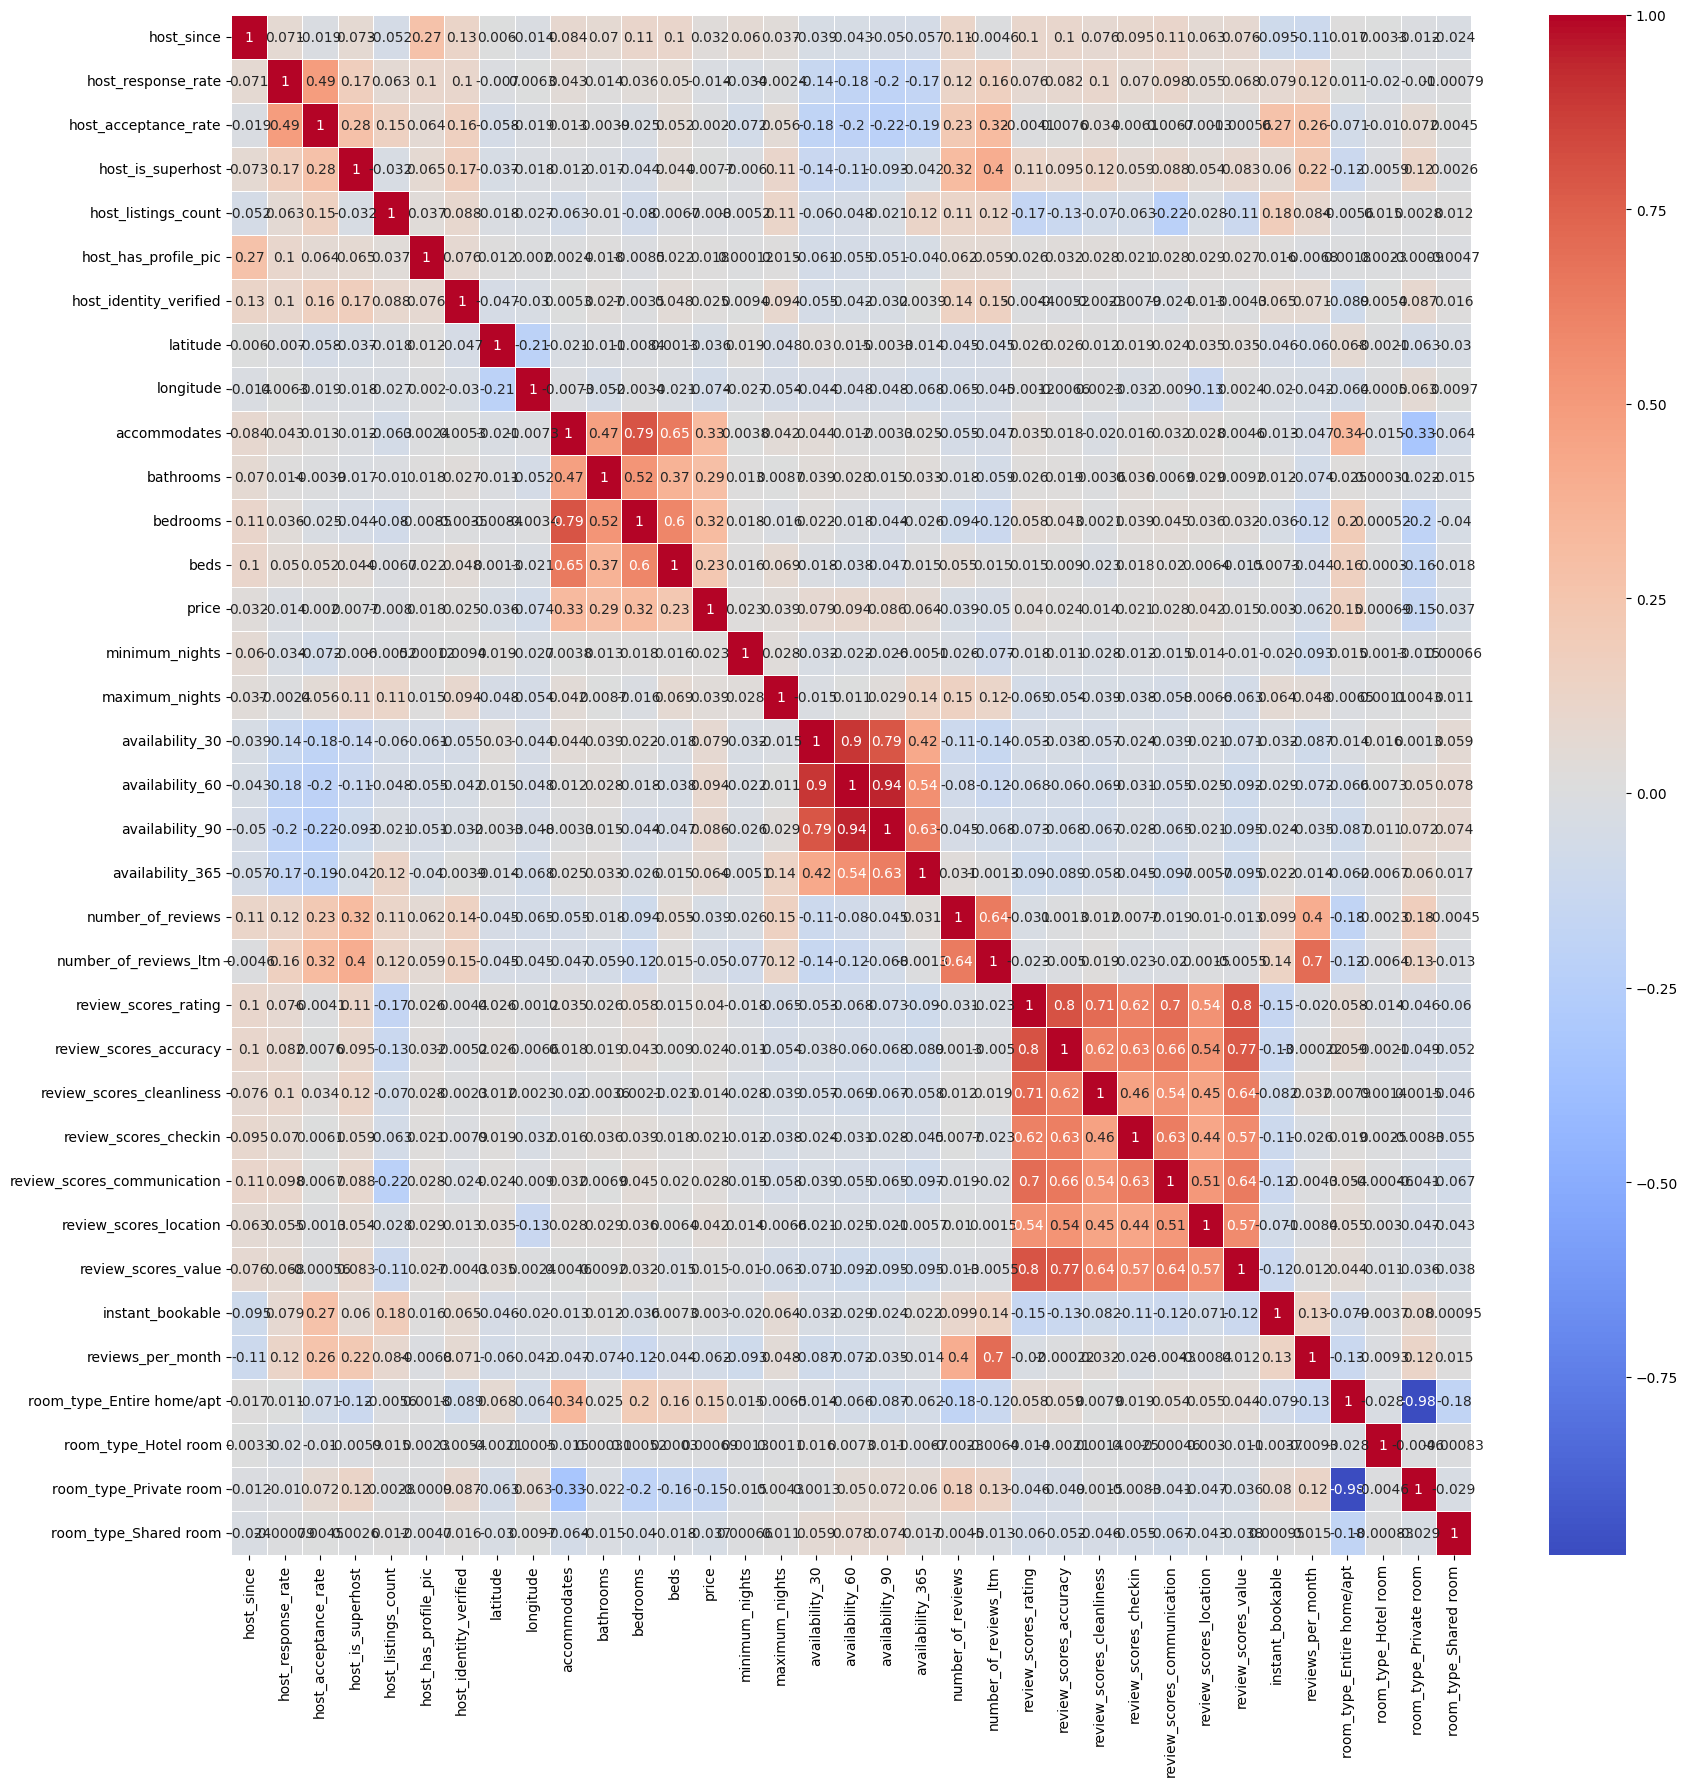

In [154]:
# Plot the correlation matrix
corr = df_cleaned.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()
